In [1]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine

from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [3]:
df = engine.getData('BTC-PERP')
df['time'] = pd.to_datetime(df['time'], unit='ms')
df = df[::-1]
df

,time,open,high,low,close,volume
1499,2021-10-17 20:40:00,59653.0,59687.0,59652.0,59662.0,258737.5221
1498,2021-10-17 20:39:00,59565.0,59653.0,59548.0,59653.0,751474.7881
1497,2021-10-17 20:38:00,59482.0,59591.0,59467.0,59565.0,460129.2528
1496,2021-10-17 20:37:00,59475.0,59605.0,59466.0,59481.0,889958.1633
1495,2021-10-17 20:36:00,59407.0,59576.0,59381.0,59480.0,942071.4424
...,...,...,...,...,...,...
4,2021-10-16 19:45:00,60990.0,60996.0,60983.0,60985.0,235582.4252
3,2021-10-16 19:44:00,60991.0,60991.0,60967.0,60990.0,171362.8391
2,2021-10-16 19:43:00,60991.0,60991.0,60990.0,60991.0,78330.7227
1,2021-10-16 19:42:00,61002.0,61002.0,60990.0,60991.0,58423.8979


In [4]:
df['just_date'] = df['time'].dt.date
df['just_date']

1499    2021-10-17
1498    2021-10-17
1497    2021-10-17
1496    2021-10-17
1495    2021-10-17
           ...    
4       2021-10-16
3       2021-10-16
2       2021-10-16
1       2021-10-16
0       2021-10-16
Name: just_date, Length: 1500, dtype: object

In [5]:
df = Algo.fullstate(df,df)
df

,time,open,high,low,close,volume,just_date,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
1478,2021-10-17 20:19:00,59792.0,59793.0,59658.0,59658.0,2.579695e+06,2021-10-17,59529.444444,59552.714286,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1477,2021-10-17 20:18:00,59809.0,59809.0,59772.0,59792.0,2.482832e+05,2021-10-17,59537.000000,59552.523810,-1.0,0.002244,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1476,2021-10-17 20:17:00,59844.0,59910.0,59800.0,59811.0,5.159243e+05,2021-10-17,59555.000000,59559.142857,-1.0,0.000318,-0.002244,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1475,2021-10-17 20:16:00,59868.0,59922.0,59823.0,59844.0,1.896552e+05,2021-10-17,59563.777778,59570.857143,-1.0,0.000552,-0.000318,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1474,2021-10-17 20:15:00,59775.0,59879.0,59717.0,59873.0,8.689017e+05,2021-10-17,59585.555556,59588.142857,-1.0,0.000484,-0.000552,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-10-16 19:45:00,60990.0,60996.0,60983.0,60985.0,2.355824e+05,2021-10-16,60947.333333,60896.095238,1.0,-0.000475,0.000000,0.0,60947.333333,1.000618,-1.0,0.0,0.000475,-1.0
3,2021-10-16 19:44:00,60991.0,60991.0,60967.0,60990.0,1.713628e+05,2021-10-16,60958.111111,60903.000000,1.0,0.000082,-0.000475,0.0,60958.111111,1.000523,-1.0,0.0,-0.000082,-1.0
2,2021-10-16 19:43:00,60991.0,60991.0,60990.0,60991.0,7.833072e+04,2021-10-16,60972.000000,60908.285714,1.0,0.000016,0.000082,0.0,60972.000000,1.000312,-1.0,0.0,-0.000016,1.0
1,2021-10-16 19:42:00,61002.0,61002.0,60990.0,60991.0,5.842390e+04,2021-10-16,60983.888889,60916.523810,1.0,0.000000,0.000016,0.0,60983.888889,1.000117,-1.0,0.0,-0.000000,1.0


In [6]:
# Set initial capital
initial_capital = float(22000.0)

# Create df positions
positions = pd.DataFrame(index=df.time.index).fillna(0.0)


# Buy 2 BTC
positions['BTCPERP'] = 1*df['signal']

# Initilize portfolio w value owned
portfolio = positions.multiply(df['close'], axis=0)

# Store diff in shares owned
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(df['close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['close'], axis=0)).sum(axis=1).cumsum()

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio['time'] = df['just_date']

In [7]:
portfolio = portfolio.reset_index(drop=True)
portfolio

,BTCPERP,holdings,cash,total,returns,time
0,-59658.0,-59658.0,22000.0,-37658.0,NaN,2021-10-17
1,-59792.0,-59792.0,22000.0,-37792.0,0.003558,2021-10-17
2,-59811.0,-59811.0,22000.0,-37811.0,0.000503,2021-10-17
3,-59844.0,-59844.0,22000.0,-37844.0,0.000873,2021-10-17
4,-59873.0,-59873.0,22000.0,-37873.0,0.000766,2021-10-17
...,...,...,...,...,...,...
1474,60985.0,60985.0,-97218.0,-36233.0,0.000801,2021-10-16
1475,60990.0,60990.0,-97218.0,-36228.0,-0.000138,2021-10-16
1476,60991.0,60991.0,-97218.0,-36227.0,-0.000028,2021-10-16
1477,60991.0,60991.0,-97218.0,-36227.0,0.000000,2021-10-16


<Figure size 7200x720 with 0 Axes>

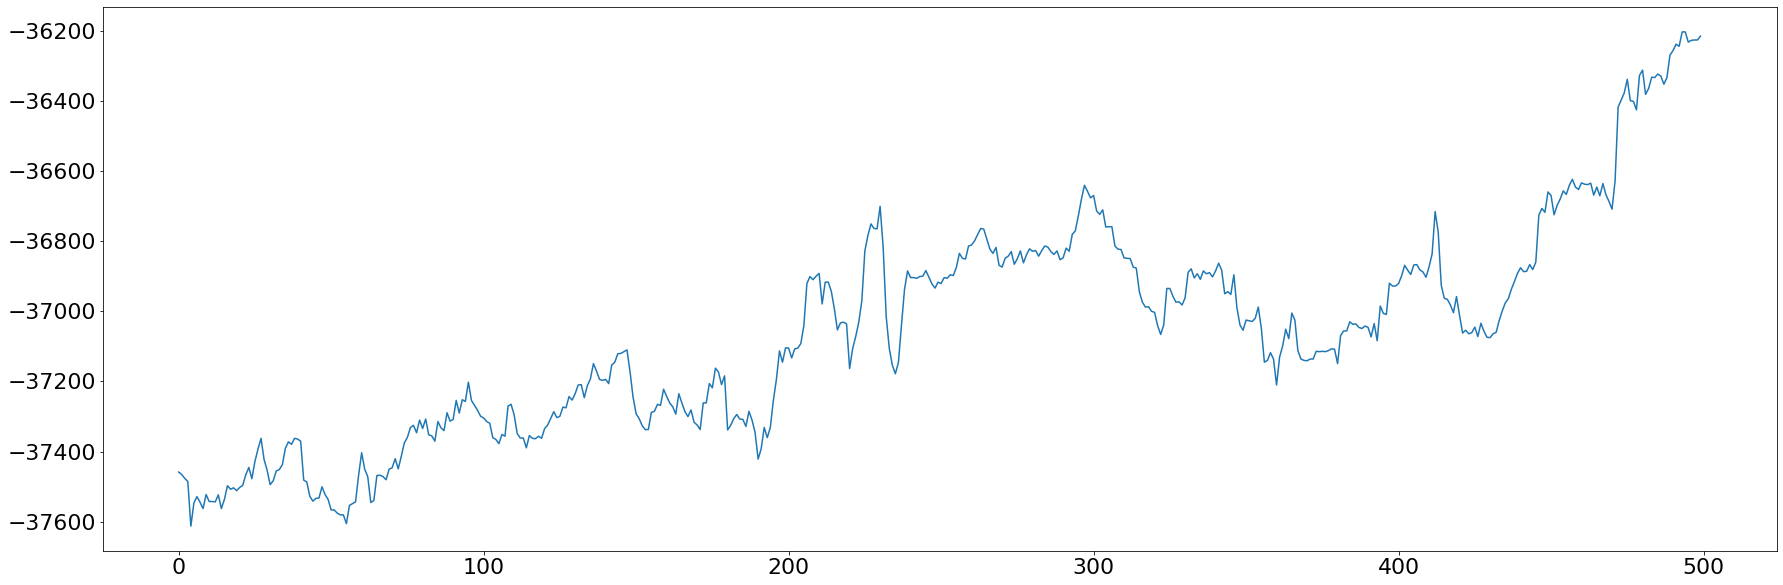

In [8]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.figure(figsize=(30, 10))
x = portfolio.iloc[-500:]['time']
y = portfolio.iloc[-500:]['total']
values = range(len(x))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.plot(values,y)
plt.savefig('../web/assets/portfolioStandings.png')
plt.show()

In [ ]:
from flask import Flask, render_template
app = Flask(__name__)
headings = ('BTC-PERP', 'holdings', 'cash', 'total', 'returns', 'time')
data = portfolio.values
@app.route("/")
def table():
    return render_template("../web/templates/portfolio.html", headings=headings, data=data)

In [ ]:
portfolio.dropna().to_csv("../web/assets/portfolio.csv")

In [ ]:
# visual look at ratio column
plt.rcParams["figure.figsize"] =  (20,7)

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

In [ ]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = (20,7)


In [ ]:
# plt.rcParams["figure.figsize"] =  (30,10)
# plt.plot(df['close'].tail(300).dropna(), label= "BTC-PERP")
# plt.plot((df['close']), (np.where(df.position > -1)), 'v', color="r", markersize=10)
# plt.plot((df['close']), (np.where(df.position < 0)),  '^', color="g", markersize=10)


In [ ]:
plt.plot(np.exp(df['returns'].tail(5000).dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].tail(5000).dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [ ]:
# # final value for each column

# print("Returns over time period specified within api call: ")
# marketR = np.exp(df['returns'].dropna()).cumprod().iloc[-1]-1
# stratR = np.exp(df['strat_return'].dropna()).cumprod().iloc[-1]-1
# percentageM = "{:.0%}".format(marketR)
# percentageS = "{:.0%}".format(stratR)
# print('Market: ', percentageM, 'Strat: ', percentageS)
# final value for each column
print("Returns over time period specified within api call: ")
print(np.exp(df['returns'].tail(5000).dropna()).cumprod().iloc[-1] -1)
print(np.exp(df['strat_return'].tail(5000).dropna()).cumprod().iloc[-1] -1)

In [ ]:
portfolio.to_csv("../web/assets/portfolio")

In [ ]:

plt.rcParams["figure.figsize"] = (15,5)

x = portfolio['startTime']
y = portfolio['total']
values = range(len(x))
plt.plot(values,y)


# Show the plot
plt.show()

In [ ]:
#column for negative and positive
df.dropna()
df['sign'] = np.where(df['strat_return'] < 0, 'neg','pos')
#consecutive groups
df['series'] = df['sign'].ne(df['sign'].shift()).cumsum()
#removed groups with length more like 2
df = df[df['series'].map(df['series'].value_counts()).gt(2)]
#tested if order `pos-neg` of groups, if not removed groups
m1 = df['sign'].eq('pos') & df['sign'].shift(-1).eq('neg')
m2 = df['sign'].eq('neg') & df['sign'].shift().eq('pos')
groups = df.loc[m1 | m2, 'series']
df = df[df['series'].isin(groups)].copy()
df['pairs'] = (df['sign'].ne(df['sign'].shift()) & df['sign'].eq('pos')).cumsum()

N = len(df['series'].dropna())
R = df['series'].dropna().nunique()
W = len(df.loc[df.strat_return.dropna() > 0])
L = len(df.loc[df.strat_return.dropna() < 0])
P = 2*W*L

# Z_score = (N*(R-0.5)-P)/((P*(P-N))/(N-1))**(1/2)
# Z_score

a = Algo(df)
b = a.Z_score(df)
b

In [ ]:
# df = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume")
# df